In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
from torch import nn

In [9]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [3]:
from pathlib import Path
data_path = Path("C:/Users/Imtiaz/Downloads/Compressed/lung_colon_image_set")
output = Path("C:/Users/Imtiaz/Downloads/Compressed/lung_colon_image_set/dataset")
image_path = data_path/"dataset" 
train_dir = image_path/"train" 
val_dir = image_path/"val"
test_dir = image_path/"test"

In [ ]:
from torchvision import transforms, datasets

manual_transform = transforms.Compose([
    transforms.Resize(size=(192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7290, 0.6000, 0.8762],
                         std=[0.1752, 0.2094, 0.0970]), 
    transforms.RandomHorizontalFlip(p=-0.2)                  
])

pred_transform = transforms.Compose([
    transforms.Resize(size=(192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7290, 0.6000, 0.8762], 
                         std=[0.1752, 0.2094, 0.0970]) 
])

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform = manual_transform) 
val_data = datasets.ImageFolder(root=val_dir, 
                                 transform = manual_transform)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform = pred_transform)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader, test_dataloader, val_dataloader = (
    DataLoader(dataset=train_data, batch_size=32, num_workers=10, shuffle=True),
    DataLoader(dataset=val_data, batch_size=32, num_workers=10, shuffle=False),
    DataLoader(dataset=test_data, batch_size=32, num_workers=10, shuffle=False)
    )
                                
class_names = train_data.classes 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class  LungDisease_Classifier(nn.Module):
    def __init__(self, num_classes=5):
        super( LungDisease_Classifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flattened_size = 64 * 24 * 24  

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
model =  LungDisease_Classifier(num_classes=5).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

from torchinfo import summary
summary(model, input_size=(1, 3, 192, 192)) 

Layer (type:depth-idx)                   Output Shape              Param #
LungDisease_Classifier                   [1, 5]                    --
├─Sequential: 1-1                        [1, 64, 24, 24]           --
│    └─Conv2d: 2-1                       [1, 16, 192, 192]         448
│    └─ReLU: 2-2                         [1, 16, 192, 192]         --
│    └─MaxPool2d: 2-3                    [1, 16, 96, 96]           --
│    └─Conv2d: 2-4                       [1, 32, 96, 96]           4,640
│    └─ReLU: 2-5                         [1, 32, 96, 96]           --
│    └─MaxPool2d: 2-6                    [1, 32, 48, 48]           --
│    └─Conv2d: 2-7                       [1, 64, 48, 48]           18,496
│    └─ReLU: 2-8                         [1, 64, 48, 48]           --
│    └─MaxPool2d: 2-9                    [1, 64, 24, 24]           --
├─Sequential: 1-2                        [1, 5]                    --
│    └─Flatten: 2-10                     [1, 36864]                --
│    └─

In [33]:
import engine
from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)
end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4653 | train_acc: 0.7918 | test_loss: 0.2762 | test_acc: 0.8999
Epoch: 2 | train_loss: 0.2506 | train_acc: 0.9018 | test_loss: 0.2036 | test_acc: 0.9173
Epoch: 3 | train_loss: 0.1942 | train_acc: 0.9256 | test_loss: 0.1602 | test_acc: 0.9399
Epoch: 4 | train_loss: 0.1448 | train_acc: 0.9448 | test_loss: 0.1315 | test_acc: 0.9502
Epoch: 5 | train_loss: 0.1128 | train_acc: 0.9580 | test_loss: 0.1328 | test_acc: 0.9533
Epoch: 6 | train_loss: 0.0937 | train_acc: 0.9656 | test_loss: 0.1208 | test_acc: 0.9466
Epoch: 7 | train_loss: 0.0777 | train_acc: 0.9714 | test_loss: 0.1122 | test_acc: 0.9577
Epoch: 8 | train_loss: 0.0593 | train_acc: 0.9788 | test_loss: 0.0741 | test_acc: 0.9731
Epoch: 9 | train_loss: 0.0503 | train_acc: 0.9813 | test_loss: 0.0912 | test_acc: 0.9676
Epoch: 10 | train_loss: 0.0362 | train_acc: 0.9885 | test_loss: 0.0814 | test_acc: 0.9735
Total Training Time: 1127.397 seconds


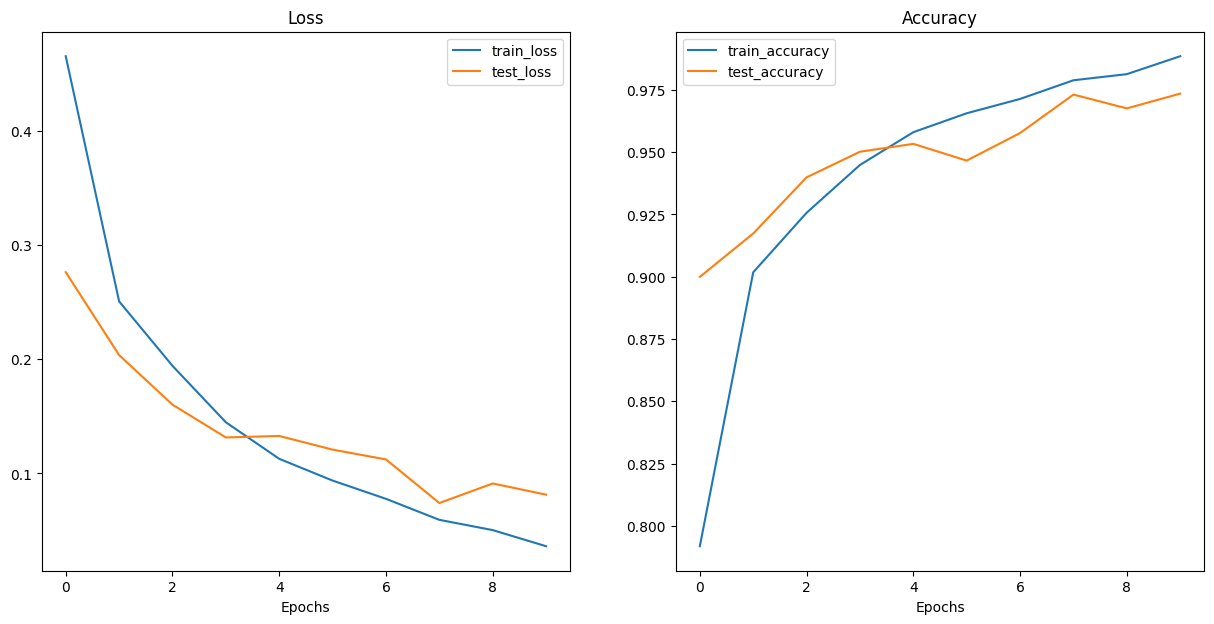

In [34]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [ ]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (232, 232),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
    transforms.Resize(size=(192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7290, 0.6000, 0.8762], 
                         std=[0.1752, 0.2094, 0.0970]) 
])

    model.to(device)

    model.eval()
    with torch.inference_mode():
      
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

In [ ]:
image_path = "C:/Users/Imtiaz/Downloads/Compressed/lung_colon_image_set/dataset/test/colon_n/colonn729.jpeg"
model =  LungDisease_Classifier(num_classes=5).to(device)

model_s = model.load_state_dict(torch.load('C:/Users/Imtiaz/Downloads/Compressed/lung_colon_image_set/LungDisease_Classifier.pth'))
pred_and_plot_image(model=model_s, 
                        image_path=image_path,
                        class_names=train_data.classes,
                        image_size=(192, 192))

In [37]:
torch.save(model.state_dict(),'LungDisease_Classifier.pth')

In [18]:
model.load_state_dict(torch.load('C:/Users/Imtiaz/Downloads/Compressed/lung_colon_image_set/LungDisease_Classifier.pth'))
model.eval()

LungDisease_Classifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=36864, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [ ]:
import torch
from tqdm import tqdm

def get_predictions_and_labels(model, dataloader, device):

    model.eval() 
    y_preds = []
    y_true = []

    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Processing batches"):
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.argmax(y_logit, dim=1)
            y_preds.extend(y_pred.cpu().numpy())
            y_true.extend(y.cpu().numpy())

    y_preds = torch.tensor(y_preds)
    y_true = torch.tensor(y_true)

    return y_preds, y_true

In [40]:
y_preds, y_true = get_predictions_and_labels(model, test_dataloader, device)

Processing batches: 100%|██████████| 79/79 [00:41<00:00,  1.92it/s]


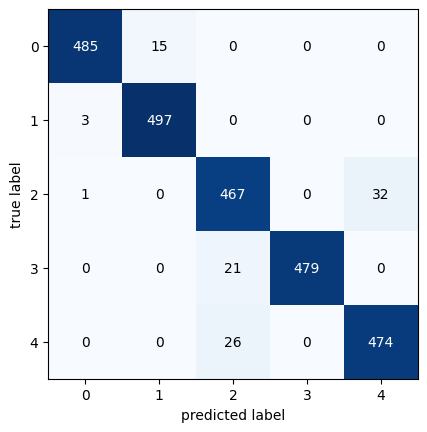

In [43]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix

cm = confusion_matrix(y_target=y_true, y_predicted=y_preds)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import gradio as gr


model_path = "C:/Users/Imtiaz/Downloads/Compressed/lung_colon_image_set/LungDisease_Classifier.pth"  # Replace with your saved model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model =  LungDisease_Classifier(num_classes=5).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))

model.eval() 


transform = transforms.Compose([
    transforms.Resize((192, 192)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7290, 0.6000, 0.8762],
                         std=[0.1752, 0.2094, 0.0970])
])


class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'] 


def predict_image(img):
    img = transform(img).unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(img)  
        probabilities = F.softmax(output, dim=1)  
        pred_idx = torch.argmax(probabilities, dim=1).item()  
        confidence = probabilities[0, pred_idx].item()
    
    return {class_names[i]: float(probabilities[0, i]) for i in range(len(class_names))}

interface = gr.Interface(
    fn=predict_image, 
    inputs=gr.Image(type="pil"), 
    outputs=gr.Label(num_top_classes=3), 
    title="Image Classifier",
    description="Upload an image to classify it using the trained PyTorch model."
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
